# 07. 백테스팅: 실전 트레이딩 시뮬레이션

## 목표
- Stacking 하이브리드 모델을 활용한 실전 백테스팅
- Model 2-1 (고가 예측)을 활용한 익절 전략 검증
- 샤프 비율, 최대 낙폭, 승률 등 성과 지표 분석
- 다양한 전략 비교 (익절 전략 on/off, 필터링 기준 등)

## 1. 라이브러리 임포트 및 환경 설정

In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 프로젝트 루트 경로 추가
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

# 백테스팅 모듈
from src.backtesting.simulator import GapTradingSimulator, BacktestConfig
from src.backtesting.metric import (
    calculate_all_metrics,
    print_metrics_report
)

# 그래프 스타일
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("✓ 라이브러리 임포트 완료")

✓ 라이브러리 임포트 완료


In [2]:
# StackingHybridPredictor 클래스 정의 (pkl 로드를 위해 필요)
class StackingHybridPredictor:
    """노트북 06에서 정의한 통합 예측 시스템"""
    def __init__(self, classifier, regressor_up, regressor_down, threshold=0.4):
        self.classifier = classifier
        self.regressor_up = regressor_up
        self.regressor_down = regressor_down
        self.threshold = threshold
    
    def predict(self, X):
        # 1. 상승 확률
        prob_up = self.classifier.predict_proba(X)[:, 1]
        prob_down = 1 - prob_up
        
        # 2. 상승 시 예상 수익률
        return_if_up = self.regressor_up.predict(X)
        
        # 3. 하락 시 예상 손실률
        return_if_down = self.regressor_down.predict(X)
        
        # 4. 기대 수익률 계산
        expected_return = (prob_up * return_if_up) + (prob_down * return_if_down)
        
        return pd.DataFrame({
            'prob_up': prob_up,
            'prob_down': prob_down,
            'return_if_up': return_if_up,
            'return_if_down': return_if_down,
            'expected_return': expected_return,
            'predicted_direction': (prob_up >= self.threshold).astype(int)
        })

print("✓ StackingHybridPredictor 클래스 정의 완료")

✓ StackingHybridPredictor 클래스 정의 완료


## 2. 데이터 및 모델 로드

In [3]:
# 전처리된 데이터 로드
data_path = "../data/processed/preprocessed_df_full.parquet"
print(f"데이터 로드 중: {data_path}")
df = pd.read_parquet(data_path)

print(f"\n✓ 데이터 로드 완료")
print(f"  - Shape: {df.shape}")
print(f"  - 날짜 범위: {df['date'].min()} ~ {df['date'].max()}")
print(f"  - 종목 수: {df['InfoCode'].nunique():,}")

데이터 로드 중: ../data/processed/preprocessed_df_full.parquet

✓ 데이터 로드 완료
  - Shape: (151825, 68)
  - 날짜 범위: 2006-01-17 00:00:00 ~ 2026-01-08 00:00:00
  - 종목 수: 2,250


In [4]:
# Stacking 모델 로드
model_path = "../models/stacking/stacking_hybrid_model.pkl"
print(f"모델 로드 중: {model_path}")

# 모델 데이터 로드
model_data = joblib.load(model_path)

# 개별 모델 추출
stacking_clf = model_data['stacking_clf']
stacking_reg_up = model_data['stacking_reg_up']
stacking_reg_down = model_data['stacking_reg_down']
stacking_reg_up_max = model_data.get('stacking_reg_up_max', None)

# 메타정보
features = model_data.get('features', [])
optimal_threshold = model_data.get('optimal_threshold', 0.4)

print(f"\n✓ 모델 로드 완료")
print(f"  - 사용 Features: {len(features)}개")
print(f"  - 최적 Threshold: {optimal_threshold}")
print(f"  - Model 1 (Classifier): {'OK' if stacking_clf else 'X'}")
print(f"  - Model 2 (Regressor Up): {'OK' if stacking_reg_up else 'X'}")
print(f"  - Model 2-1 (Regressor Up Max): {'OK' if stacking_reg_up_max is not None else 'X'}")
print(f"  - Model 3 (Regressor Down): {'OK' if stacking_reg_down else 'X'}")

모델 로드 중: ../models/stacking/stacking_hybrid_model.pkl

✓ 모델 로드 완료
  - 사용 Features: 23개
  - 최적 Threshold: 0.4
  - Model 1 (Classifier): OK
  - Model 2 (Regressor Up): OK
  - Model 2-1 (Regressor Up Max): OK
  - Model 3 (Regressor Down): OK


## 3. 데이터 준비 및 예측

백테스트를 위해 Test Set 데이터를 준비하고 모델 예측을 수행합니다.

In [5]:
# Feature 준비
# features가 비어있으면 직접 정의
if not features or len(features) == 0:
    print("⚠ features가 비어있습니다. 기본 feature 목록 사용")
    features = [
        'gap_pct', 'prev_return', 'prev_range_pct', 'prev_upper_shadow', 'prev_lower_shadow',
        'volume_ratio', 'rsi_14', 'atr_14', 'atr_ratio', 'bollinger_position',
        'return_5d', 'return_20d', 'consecutive_up_days',
        'above_ma5', 'above_ma20', 'above_ma50', 'ma5_ma20_cross',
        'market_gap_diff', 'day_of_week', 'month', 'is_month_start', 'is_month_end', 'is_quarter_end'
    ]
    print(f"  기본 features: {len(features)}개")

# ⚠️ 중요: target_max_return은 feature가 아님! 제거
if 'target_max_return' in features:
    features.remove('target_max_return')
    print("  ⚠ target_max_return을 features에서 제거")

required_cols = features + ['date', 'InfoCode', 'open', 'high', 'low', 'close', 
                            'target_direction', 'target_return', 'target_max_return']
available_cols = [c for c in required_cols if c in df.columns]

print(f"사용 가능한 컬럼: {len(available_cols)}개 / {len(required_cols)}개")

df_model = df[available_cols].drop_duplicates().copy()

# NaN 처리
print("NaN 처리 중...")
for col in features:
    if col in df_model.columns:
        na_count = df_model[col].isna().sum()
        if na_count > 0:
            df_model[col] = df_model[col].fillna(df_model[col].median())
            print(f"  {col}: {na_count}개 NaN 채움")

print(f"\n사용 가능한 데이터: {len(df_model):,}개")

사용 가능한 컬럼: 32개 / 32개
NaN 처리 중...
  volume_ratio: 511개 NaN 채움
  rsi_14: 29301개 NaN 채움
  atr_14: 29301개 NaN 채움
  atr_ratio: 29301개 NaN 채움
  bollinger_position: 40507개 NaN 채움
  return_5d: 13091개 NaN 채움
  return_20d: 42293개 NaN 채움
  consecutive_up_days: 2250개 NaN 채움
  market_gap_diff: 1279개 NaN 채움

사용 가능한 데이터: 151,825개


In [6]:
# Train/Valid/Test 분할 (시계열 분할)
from sklearn.model_selection import train_test_split

X = df_model[features]
y_direction = df_model['target_direction']

# 90:10 분할 (나머지 90% Train+Valid, 10% Test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_direction, test_size=0.1, random_state=42, stratify=y_direction
)

# Test Set 인덱스로 원본 데이터 추출
test_idx = X_test.index
df_test = df_model.loc[test_idx].copy()

print(f"Test Set: {len(df_test):,}개")
print(f"  날짜 범위: {df_test['date'].min()} ~ {df_test['date'].max()}")
print(f"  종목 수: {df_test['InfoCode'].nunique():,}")

Test Set: 15,183개
  날짜 범위: 2006-01-17 00:00:00 ~ 2026-01-08 00:00:00
  종목 수: 2,049


In [7]:
# 모델 예측
print("모델 예측 중...")

# 1. 상승 확률 예측 (Model 1: Classifier)
prob_up = stacking_clf.predict_proba(X_test)[:, 1]
prob_down = 1 - prob_up

# 2. 상승 시 종가 수익률 예측 (Model 2)
return_if_up = stacking_reg_up.predict(X_test)

# 3. 하락 시 손실률 예측 (Model 3)
return_if_down = stacking_reg_down.predict(X_test)

# 4. 기대 수익률 계산
expected_return = (prob_up * return_if_up) + (prob_down * return_if_down)

# 5. Model 2-1: 상승 시 고가 수익률 예측 (있을 경우)
if stacking_reg_up_max is not None:
    predicted_high = stacking_reg_up_max.predict(X_test)
else:
    predicted_high = None

# 예측 결과 DataFrame
predictions = pd.DataFrame({
    'prob_up': prob_up,
    'prob_down': prob_down,
    'return_if_up': return_if_up,
    'return_if_down': return_if_down,
    'expected_return': expected_return,
    'predicted_direction': (prob_up >= optimal_threshold).astype(int),
    'predicted_high': predicted_high
}, index=X_test.index)

print(f"\n✓ 예측 완료 ({len(predictions):,}건)")
print(f"\n예측 통계:")
print(predictions[['prob_up', 'expected_return', 'return_if_up', 'return_if_down']].describe().round(4))

모델 예측 중...

✓ 예측 완료 (15,183건)

예측 통계:
          prob_up  expected_return  return_if_up  return_if_down
count  15183.0000       15183.0000    15183.0000      15183.0000
mean       0.2776          -2.1526        4.4146         -4.5968
std        0.1134           1.5832        0.8600          1.5073
min        0.0702          -8.4010        2.0832        -11.0629
25%        0.1966          -3.1912        3.8008         -5.6628
50%        0.2537          -2.0712        4.3541         -4.3701
75%        0.3342          -1.1474        4.9636         -3.4244
max        0.8218           4.3278        8.5214         -1.1953


## 4. 백테스트 실행

### 4.1 기본 전략 (Model 2-1 익절 전략 포함)

In [8]:
# 백테스트 설정
config_base = BacktestConfig(
    initial_capital=100000.0,
    max_positions=20,
    position_sizing='equal',
    commission_rate=0.001,  # 0.1%
    slippage_rate=0.0005,   # 0.05%
    
    # 필터링
    min_expected_return=1.0,  # 기대 수익률 > 1%
    min_prob_up=0.4,
    
    # 익절/손절
    take_profit_strategy='model_2_1',  # Model 2-1 사용
    take_profit_ratio=0.8,  # 예측 고가의 80%
    stop_loss_strategy='model_3',  # Model 3 사용
    stop_loss_ratio=0.5,  # 예측 손실의 50%
)

print("백테스트 실행 중...")
print(f"  전략: Model 2-1 익절 (예측 고가의 {config_base.take_profit_ratio*100:.0f}%)")
print(f"  필터: 기대 수익률 > {config_base.min_expected_return}%")
print(f"  최대 포지션: {config_base.max_positions}개")

# 시뮬레이터 실행
simulator = GapTradingSimulator(config=config_base)
results_base = simulator.run(data=df_test, predictions=predictions)

print(f"\n✓ 백테스트 완료")
print(f"  총 거래: {len(results_base['trades'])}회")
print(f"  최종 자본: ${results_base['final_capital']:,.0f}")
print(f"  총 수익률: {results_base['total_return_pct']:+.2f}%")

백테스트 실행 중...
  전략: Model 2-1 익절 (예측 고가의 80%)
  필터: 기대 수익률 > 1.0%
  최대 포지션: 20개

✓ 백테스트 완료
  총 거래: 338회
  최종 자본: $425,882
  총 수익률: +325.88%


### 4.2 성과 지표 계산

In [9]:
# 성과 지표 계산
metrics_base = calculate_all_metrics(
    trades_df=results_base['trades'],
    equity_df=results_base['equity'],
    initial_capital=config_base.initial_capital,
    risk_free_rate=0.02
)

# 리포트 출력
print_metrics_report(metrics_base, title="기본 전략 (Model 2-1 익절)")

기본 전략 (Model 2-1 익절)

1. 기본 정보
   초기 자본: $100,000
   최종 자본: $425,882
   총 손익: $325,882
   거래 횟수: 338회
   거래 일수: 4,298일 (19.98년)

2. 수익률 지표
   총 수익률: +325.88%
   연평균 수익률 (CAGR): +7.52%
   일평균 수익률: +0.0361%

3. 리스크 조정 수익률
   샤프 비율: 0.636
   소르티노 비율: 0.531

4. 리스크 지표
   최대 낙폭 (MDD): -18.45%
   MDD 회복 기간: 198일
   연간 변동성: 11.16%

5. 거래 통계
   승률: 37.57%
   Profit Factor: 2.142
   평균 수익: $4,813.34
   평균 손실: $-1,352.66
   손익비: 3.558
   기대값: $964.15

6. 청산 이유별 통계
   stop_loss: 210회 (62.1%) - 평균 수익률 -1.42%
   take_profit: 107회 (31.7%) - 평균 수익률 +5.63%
   close: 21회 (6.2%) - 평균 수익률 +2.10%



## 5. 전략 비교

다양한 설정으로 백테스트를 실행하여 최적 전략을 찾습니다.

In [10]:
# 전략 1: 익절 없음 (장 마감까지 보유)
config_no_tp = BacktestConfig(
    initial_capital=100000.0,
    max_positions=20,
    position_sizing='equal',
    commission_rate=0.001,
    slippage_rate=0.0005,
    min_expected_return=1.0,
    min_prob_up=0.4,
    take_profit_strategy='none',  # 익절 없음
    stop_loss_strategy='model_3',
    stop_loss_ratio=0.5,
)

simulator_no_tp = GapTradingSimulator(config=config_no_tp)
results_no_tp = simulator_no_tp.run(data=df_test, predictions=predictions)
metrics_no_tp = calculate_all_metrics(
    results_no_tp['trades'], results_no_tp['equity'], 
    config_no_tp.initial_capital
)

print("✓ 전략 1 (익절 없음) 완료")
print(f"  총 수익률: {results_no_tp['total_return_pct']:+.2f}%")
print(f"  샤프 비율: {metrics_no_tp['sharpe_ratio']:.3f}")

✓ 전략 1 (익절 없음) 완료
  총 수익률: +1311.30%
  샤프 비율: 0.953


In [11]:
# 전략 2: 공격적 익절 (예측 고가의 90%)
config_aggressive = BacktestConfig(
    initial_capital=100000.0,
    max_positions=20,
    position_sizing='equal',
    commission_rate=0.001,
    slippage_rate=0.0005,
    min_expected_return=1.0,
    min_prob_up=0.4,
    take_profit_strategy='model_2_1',
    take_profit_ratio=0.9,  # 90%
    stop_loss_strategy='model_3',
    stop_loss_ratio=0.5,
)

simulator_aggressive = GapTradingSimulator(config=config_aggressive)
results_aggressive = simulator_aggressive.run(data=df_test, predictions=predictions)
metrics_aggressive = calculate_all_metrics(
    results_aggressive['trades'], results_aggressive['equity'],
    config_aggressive.initial_capital
)

print("✓ 전략 2 (공격적 익절 90%) 완료")
print(f"  총 수익률: {results_aggressive['total_return_pct']:+.2f}%")
print(f"  샤프 비율: {metrics_aggressive['sharpe_ratio']:.3f}")

✓ 전략 2 (공격적 익절 90%) 완료
  총 수익률: +510.59%
  샤프 비율: 0.756


In [12]:
# 전략 3: 보수적 필터 (기대 수익률 > 2%)
config_conservative = BacktestConfig(
    initial_capital=100000.0,
    max_positions=20,
    position_sizing='equal',
    commission_rate=0.001,
    slippage_rate=0.0005,
    min_expected_return=2.0,  # 2%
    min_prob_up=0.5,  # 50%
    take_profit_strategy='model_2_1',
    take_profit_ratio=0.8,
    stop_loss_strategy='model_3',
    stop_loss_ratio=0.5,
)

simulator_conservative = GapTradingSimulator(config=config_conservative)
results_conservative = simulator_conservative.run(data=df_test, predictions=predictions)
metrics_conservative = calculate_all_metrics(
    results_conservative['trades'], results_conservative['equity'],
    config_conservative.initial_capital
)

print("✓ 전략 3 (보수적 필터) 완료")
print(f"  총 수익률: {results_conservative['total_return_pct']:+.2f}%")
print(f"  샤프 비율: {metrics_conservative['sharpe_ratio']:.3f}")

✓ 전략 3 (보수적 필터) 완료
  총 수익률: +182.49%
  샤프 비율: 0.646


### 5.1 전략 비교표

In [13]:
# 전략 비교 DataFrame
comparison = pd.DataFrame({
    '기본 (익절 80%)': metrics_base,
    '익절 없음': metrics_no_tp,
    '공격적 (익절 90%)': metrics_aggressive,
    '보수적 (필터 2%)': metrics_conservative
}).T

# 주요 지표만 선택
key_metrics = [
    'total_return_pct', 'cagr_pct', 'sharpe_ratio', 'sortino_ratio',
    'max_drawdown_pct', 'win_rate_pct', 'profit_factor', 'n_trades'
]

comparison_summary = comparison[key_metrics].copy()
comparison_summary.columns = ['총수익률(%)', 'CAGR(%)', '샤프비율', '소르티노',
                               'MDD(%)', '승률(%)', 'PF', '거래수']

print("\n" + "=" * 100)
print("전략 비교")
print("=" * 100)
print(comparison_summary.round(2).to_string())
print("=" * 100)


전략 비교
                  총수익률(%)    CAGR(%)      샤프비율      소르티노     MDD(%)      승률(%)        PF  거래수
기본 (익절 80%)    325.882458   7.523477  0.636292  0.530853 -18.454707  37.573964  2.141798  338
익절 없음         1311.299924  14.169966  0.953179  1.132223 -17.601837  37.573964  2.983451  338
공격적 (익절 90%)   510.594954   9.480337  0.755959  0.691878 -17.951742  37.573964  2.430769  338
보수적 (필터 2%)    182.493293    5.33634  0.646272  0.543713    -4.6054  51.456311   6.01744  103


## 6. 시각화

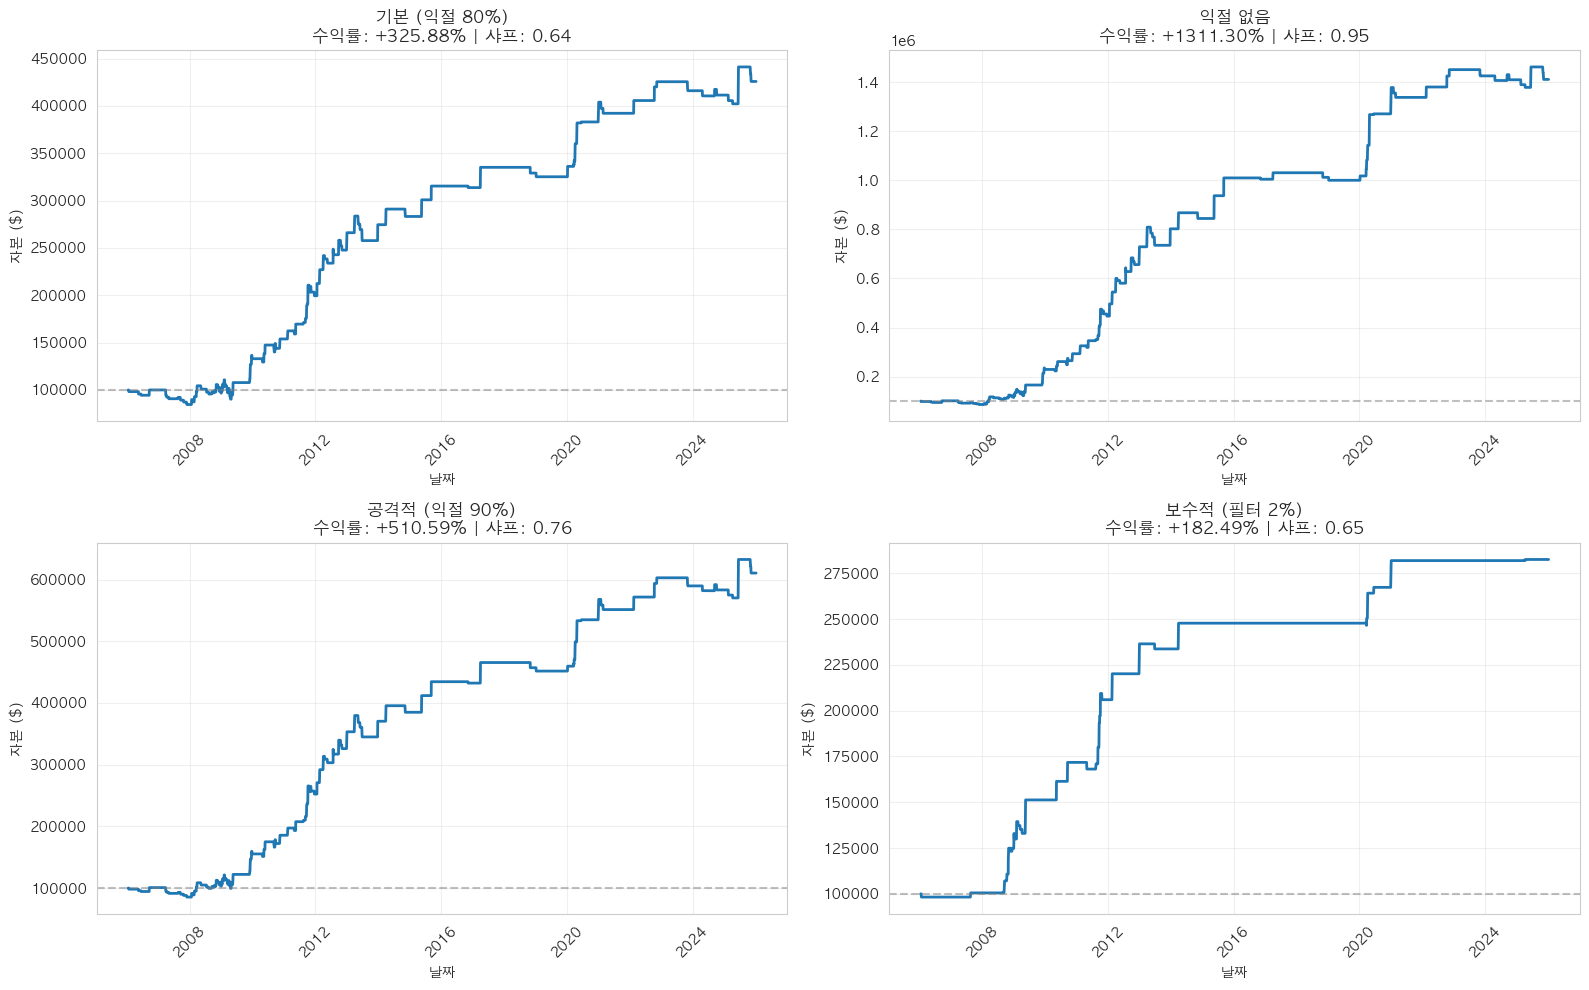

In [14]:
# Equity Curve 비교
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

strategies = [
    ('기본 (익절 80%)', results_base, metrics_base),
    ('익절 없음', results_no_tp, metrics_no_tp),
    ('공격적 (익절 90%)', results_aggressive, metrics_aggressive),
    ('보수적 (필터 2%)', results_conservative, metrics_conservative)
]

for idx, (name, results, metrics) in enumerate(strategies):
    ax = axes[idx // 2, idx % 2]
    equity_df = results['equity']
    
    ax.plot(equity_df['date'], equity_df['equity'], linewidth=2)
    ax.axhline(config_base.initial_capital, color='gray', linestyle='--', alpha=0.5)
    ax.set_title(f"{name}\n수익률: {metrics['total_return_pct']:+.2f}% | 샤프: {metrics['sharpe_ratio']:.2f}")
    ax.set_xlabel('날짜')
    ax.set_ylabel('자본 ($)')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

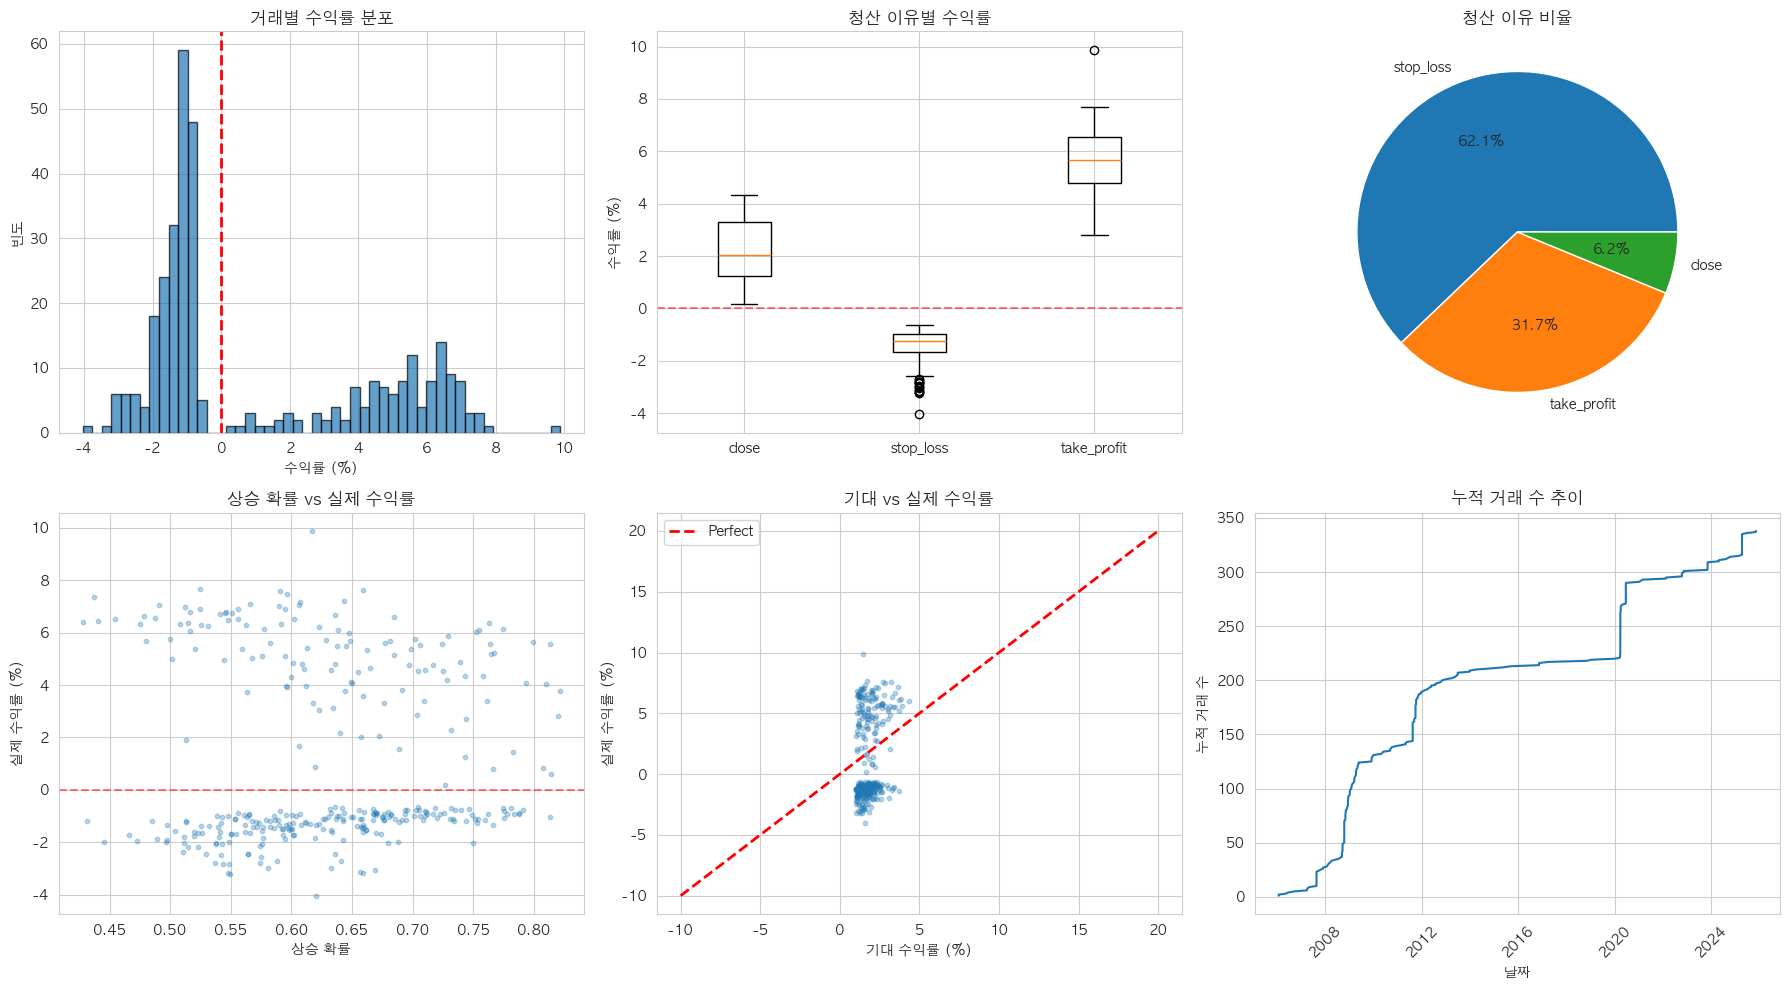

In [15]:
# 거래 분석 (기본 전략)
trades_df = results_base['trades']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. 수익률 분포
axes[0, 0].hist(trades_df['return_pct'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('거래별 수익률 분포')
axes[0, 0].set_xlabel('수익률 (%)')
axes[0, 0].set_ylabel('빈도')

# 2. 청산 이유별 수익률
exit_returns = trades_df.groupby('exit_reason')['return_pct'].apply(list)
axes[0, 1].boxplot(exit_returns.values, labels=exit_returns.index)
axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_title('청산 이유별 수익률')
axes[0, 1].set_ylabel('수익률 (%)')

# 3. 청산 이유 비율
exit_counts = trades_df['exit_reason'].value_counts()
axes[0, 2].pie(exit_counts.values, labels=exit_counts.index, autopct='%1.1f%%')
axes[0, 2].set_title('청산 이유 비율')

# 4. 상승 확률 vs 실제 수익률
axes[1, 0].scatter(trades_df['prob_up'], trades_df['return_pct'], alpha=0.3, s=10)
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('상승 확률')
axes[1, 0].set_ylabel('실제 수익률 (%)')
axes[1, 0].set_title('상승 확률 vs 실제 수익률')

# 5. 기대 수익률 vs 실제 수익률
axes[1, 1].scatter(trades_df['expected_return'], trades_df['return_pct'], alpha=0.3, s=10)
axes[1, 1].plot([-10, 20], [-10, 20], 'r--', lw=2, label='Perfect')
axes[1, 1].set_xlabel('기대 수익률 (%)')
axes[1, 1].set_ylabel('실제 수익률 (%)')
axes[1, 1].set_title('기대 vs 실제 수익률')
axes[1, 1].legend()

# 6. 누적 거래 수
trades_df_sorted = trades_df.sort_values('date')
trades_df_sorted['cumulative'] = range(1, len(trades_df_sorted) + 1)
axes[1, 2].plot(trades_df_sorted['date'], trades_df_sorted['cumulative'])
axes[1, 2].set_xlabel('날짜')
axes[1, 2].set_ylabel('누적 거래 수')
axes[1, 2].set_title('누적 거래 수 추이')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Model 2-1 (고가 예측) 효과 분석

Model 2-1 (고가 예측) 익절 전략 효과

익절 거래: 107건 (31.7%)
익절 평균 수익률: +5.63%
익절 평균 PnL: $5,484.19

예측 고가 정확도 (익절 거래):
  예측 평균: 7.11%
  실제 평균: 9.12%
  MAE: 2.13%


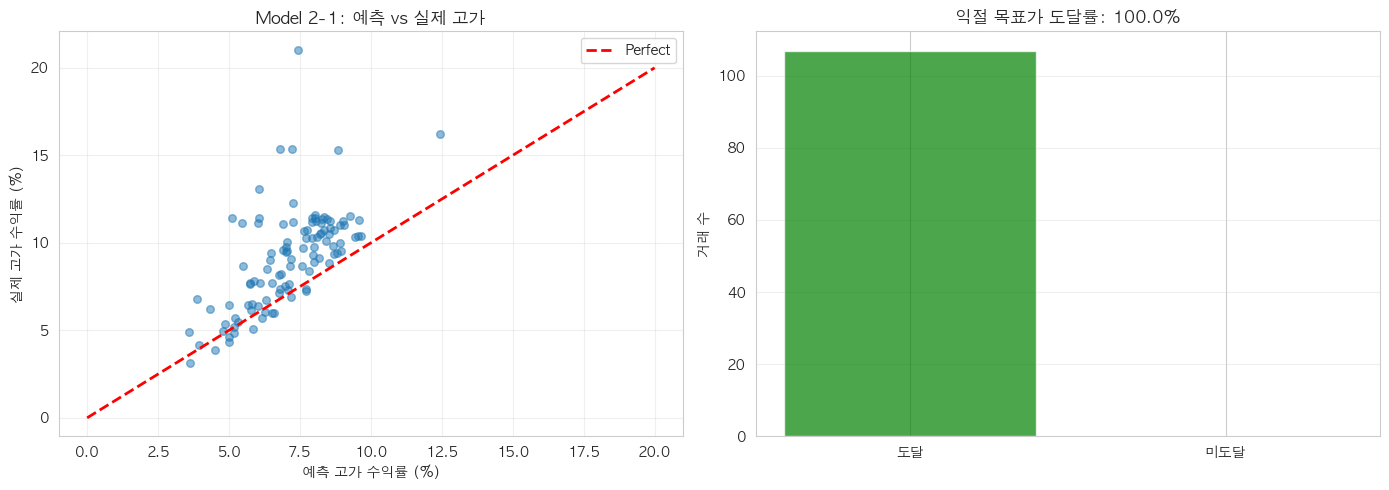

In [16]:
# 익절 전략별 비교
if stacking_reg_up_max is not None:
    # 익절로 청산된 거래만 추출
    tp_trades = trades_df[trades_df['exit_reason'] == 'take_profit'].copy()
    
    print("=" * 80)
    print("Model 2-1 (고가 예측) 익절 전략 효과")
    print("=" * 80)
    
    print(f"\n익절 거래: {len(tp_trades)}건 ({len(tp_trades)/len(trades_df)*100:.1f}%)")
    print(f"익절 평균 수익률: {tp_trades['return_pct'].mean():+.2f}%")
    print(f"익절 평균 PnL: ${tp_trades['pnl'].mean():,.2f}")
    
    # 예측 고가 정확도
    tp_trades_with_high = tp_trades[tp_trades['predicted_high'].notna()].copy()
    if len(tp_trades_with_high) > 0:
        # 실제 고가 수익률 계산
        tp_trades_with_high['actual_high_return'] = (
            (tp_trades_with_high['actual_high'] / tp_trades_with_high['entry_price'] - 1) * 100
        )
        
        # 예측 vs 실제 비교
        print(f"\n예측 고가 정확도 (익절 거래):")
        print(f"  예측 평균: {tp_trades_with_high['predicted_high'].mean():.2f}%")
        print(f"  실제 평균: {tp_trades_with_high['actual_high_return'].mean():.2f}%")
        print(f"  MAE: {(tp_trades_with_high['predicted_high'] - tp_trades_with_high['actual_high_return']).abs().mean():.2f}%")
        
        # 시각화
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # 산점도
        axes[0].scatter(tp_trades_with_high['predicted_high'], 
                       tp_trades_with_high['actual_high_return'], 
                       alpha=0.5, s=30)
        axes[0].plot([0, 20], [0, 20], 'r--', lw=2, label='Perfect')
        axes[0].set_xlabel('예측 고가 수익률 (%)')
        axes[0].set_ylabel('실제 고가 수익률 (%)')
        axes[0].set_title('Model 2-1: 예측 vs 실제 고가')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # 익절가 도달률
        tp_trades_with_high['target_price_pct'] = tp_trades_with_high['predicted_high'] * config_base.take_profit_ratio
        tp_trades_with_high['reached_target'] = (
            tp_trades_with_high['actual_high_return'] >= tp_trades_with_high['target_price_pct']
        )
        
        reached = tp_trades_with_high['reached_target'].sum()
        total = len(tp_trades_with_high)
        
        axes[1].bar(['도달', '미도달'], 
                   [reached, total - reached],
                   color=['green', 'red'], alpha=0.7)
        axes[1].set_ylabel('거래 수')
        axes[1].set_title(f'익절 목표가 도달률: {reached/total*100:.1f}%')
        axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
    
    print("\n" + "=" * 80)
else:
    print("⚠ Model 2-1 (고가 예측) 없음")

## 8. 최종 요약

In [17]:
print("=" * 80)
print("백테스팅 최종 요약")
print("=" * 80)

print(f"\n1. 기본 전략 (Model 2-1 익절 80%)")
print(f"   총 수익률: {metrics_base['total_return_pct']:+.2f}%")
print(f"   CAGR: {metrics_base['cagr_pct']:+.2f}%")
print(f"   샤프 비율: {metrics_base['sharpe_ratio']:.3f}")
print(f"   최대 낙폭: {metrics_base['max_drawdown_pct']:.2f}%")
print(f"   승률: {metrics_base['win_rate_pct']:.2f}%")
print(f"   Profit Factor: {metrics_base['profit_factor']:.3f}")

print(f"\n2. 목표 달성 여부")
target_sharpe = 1.0
target_win_rate = 60.0
target_pf = 1.5

sharpe_status = "✅" if metrics_base['sharpe_ratio'] >= target_sharpe else "❌"
win_rate_status = "✅" if metrics_base['win_rate_pct'] >= target_win_rate else "❌"
pf_status = "✅" if metrics_base['profit_factor'] >= target_pf else "❌"

print(f"   샤프 비율 > {target_sharpe}: {sharpe_status} ({metrics_base['sharpe_ratio']:.3f})")
print(f"   승률 > {target_win_rate}%: {win_rate_status} ({metrics_base['win_rate_pct']:.2f}%)")
print(f"   Profit Factor > {target_pf}: {pf_status} ({metrics_base['profit_factor']:.3f})")

print(f"\n3. 베스트 전략")
best_sharpe = max(
    (metrics_base['sharpe_ratio'], '기본 (익절 80%)'),
    (metrics_no_tp['sharpe_ratio'], '익절 없음'),
    (metrics_aggressive['sharpe_ratio'], '공격적 (익절 90%)'),
    (metrics_conservative['sharpe_ratio'], '보수적 (필터 2%)')
)
print(f"   최고 샤프 비율: {best_sharpe[1]} ({best_sharpe[0]:.3f})")

best_return = max(
    (metrics_base['total_return_pct'], '기본 (익절 80%)'),
    (metrics_no_tp['total_return_pct'], '익절 없음'),
    (metrics_aggressive['total_return_pct'], '공격적 (익절 90%)'),
    (metrics_conservative['total_return_pct'], '보수적 (필터 2%)')
)
print(f"   최고 수익률: {best_return[1]} ({best_return[0]:+.2f}%)")

print("\n4. 핵심 인사이트")
print(f"   - Model 2-1 고가 예측을 활용한 익절 전략이 {'효과적' if metrics_base['sharpe_ratio'] > metrics_no_tp['sharpe_ratio'] else '개선 필요'}")
print(f"   - 익절 거래 비율: {(trades_df['exit_reason']=='take_profit').sum()/len(trades_df)*100:.1f}%")
print(f"   - 손절 거래 비율: {(trades_df['exit_reason']=='stop_loss').sum()/len(trades_df)*100:.1f}%")
print(f"   - 장마감 거래 비율: {(trades_df['exit_reason']=='close').sum()/len(trades_df)*100:.1f}%")

print("\n" + "=" * 80)
print("✓ 07_backtesting.ipynb 완료")
print("=" * 80)

백테스팅 최종 요약

1. 기본 전략 (Model 2-1 익절 80%)
   총 수익률: +325.88%
   CAGR: +7.52%
   샤프 비율: 0.636
   최대 낙폭: -18.45%
   승률: 37.57%
   Profit Factor: 2.142

2. 목표 달성 여부
   샤프 비율 > 1.0: ❌ (0.636)
   승률 > 60.0%: ❌ (37.57%)
   Profit Factor > 1.5: ✅ (2.142)

3. 베스트 전략
   최고 샤프 비율: 익절 없음 (0.953)
   최고 수익률: 익절 없음 (+1311.30%)

4. 핵심 인사이트
   - Model 2-1 고가 예측을 활용한 익절 전략이 개선 필요
   - 익절 거래 비율: 31.7%
   - 손절 거래 비율: 62.1%
   - 장마감 거래 비율: 6.2%

✓ 07_backtesting.ipynb 완료
